# **Importing Modules**

In [1]:
from keras.models import Model  #Imports the base class for building neural network models.
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout
from keras.layers import concatenate
from tensorflow.keras.preprocessing import image
import numpy as np 
import pandas as pd
import cv2
import os
from PIL import Image

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train_data_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'

normal = os.listdir('{}/{}'.format(train_data_path,'NORMAL')) # GET LIST OF NORMAL IMAGES
pneumonia = os.listdir('{}/{}'.format(train_data_path,'PNEUMONIA')) #GET LIST OF PNEUMONIA IMAGES

# Initialize lists to store image data and labels
image_data = []
labels = []

def preprocess_image(image_path):
    # Load and preprocess a single image
    image = Image.open(image_path)
    image = image.resize((224, 224))  # Resize to 224x224 pixels
    if image.mode != "L":
        image = image.convert("L")  # Convert to grayscale if not already
    image_array = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image_array

for i in normal:
    image_path = '{}/{}/{}'.format(train_data_path,'NORMAL',i)
    image_array = preprocess_image(image_path)
    image_data.append(image_array)
    labels.append(0)

    
    
for i in pneumonia:
    image_path = '{}/{}/{}'.format(train_data_path,'PNEUMONIA',i)
    image_array = preprocess_image(image_path)
    image_data.append(image_array)
    labels.append(1) 
    
# Convert the lists to NumPy arrays
image_data = np.array(image_data)
labels = np.array(labels)

# Ensure the shape matches (None, 224, 224, 1)
image_data = image_data.reshape(5216, 224, 224, 1)
# image_data = np.expand_dims(image_data, axis=-1)


In [3]:
test_data_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'

normal = os.listdir('{}/{}'.format(test_data_path,'NORMAL')) # GET LIST OF NORMAL IMAGES
pneumonia = os.listdir('{}/{}'.format(test_data_path,'PNEUMONIA')) #GET LIST OF PNEUMONIA IMAGES


# Initialize lists to store image data and labels
test_image_data = []
test_image_labels = []

def preprocess_image(image_path):
    # Load and preprocess a single image
    image = Image.open(image_path)
    image = image.resize((224, 224))  # Resize to 224x224 pixels
    if image.mode != "L":
        image = image.convert("L")  # Convert to grayscale if not already
    image_array = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image_array

for i in normal:
    image_path = '{}/{}/{}'.format(test_data_path,'NORMAL',i)
    image_array = preprocess_image(image_path)
    test_image_data.append(image_array)
    test_image_labels.append(0)

    
    
for i in pneumonia:
    image_path = '{}/{}/{}'.format(test_data_path,'PNEUMONIA',i)
    image_array = preprocess_image(image_path)
    test_image_data.append(image_array)
    test_image_labels.append(1) 
    
# Convert the lists to NumPy arrays
test_image_data = np.array(test_image_data)
test_image_labels = np.array(test_image_labels)
print(test_image_data.size)
# Ensure the shape matches (None, 224, 224, 1)
test_image_data = test_image_data.reshape(624, 224, 224, 1)


31309824


## Inception layer


In [4]:
def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
  # Input: 
  # - f1: number of filters of the 1x1 convolutional layer in the first path
  # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
  # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
  # - f4: number of filters of the 1x1 convolutional layer in the fourth path

  # 1st path
  path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

  # 2nd path
  path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

  # 3rd path
  path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

  # 4th path
  path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
  path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

  output_layer = concatenate([path1, path2, path3, path4], axis = -1)

  return output_layer

In [5]:
def GoogLeNet():
  # input layer 
  input_layer = Input(shape = (224, 224, 1))

  # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
  X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # convolutional layer: filters = 64, strides = 1
  X = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')(X)

  # convolutional layer: filters = 192, kernel_size = (3,3)
  X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(X)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 1st Inception block
  X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

  # 2nd Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 3rd Inception block
  X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)

  # Extra network 1:
  X1 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X1 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X1)
  X1 = Flatten()(X1)
  X1 = Dense(1024, activation = 'relu')(X1)
  X1 = Dropout(0.7)(X1)
  X1 = Dense(1, activation = 'sigmoid')(X1)

  
  # 4th Inception block
  X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 5th Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 6th Inception block
  X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

  # Extra network 2:
  X2 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X2 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X2)
  X2 = Flatten()(X2)
  X2 = Dense(1024, activation = 'relu')(X2)
  X2 = Dropout(0.6)(X2)
  X2 = Dense(1, activation = 'sigmoid')(X2)
  
  
  # 7th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, 
                      f3_conv5 = 128, f4 = 128)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # 8th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

  # 9th Inception block
  X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

  # Global Average pooling layer 
  X = GlobalAveragePooling2D(name = 'GAPL')(X)

  # Dropoutlayer 
  X = Dropout(0.5)(X)

  # output layer 
  X = Dense(1, activation = 'sigmoid')(X)
  
  # model
  model = Model(input_layer, [X, X1, X2], name = 'GoogLeNet')

  return model

In [6]:
from keras.preprocessing.image import ImageDataGenerator

# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow(
    x=image_data,
    y=labels,
    batch_size=32)

# Define a new model
model = GoogLeNet()
metrics_list = ['accuracy']

# Compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=metrics_list)




In [7]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath='/kaggle/working/best_model.h5', monitor='val_dense_3_accuracy', save_best_only=True, verbose=1)

In [8]:
hist = model.fit(
    train_generator,
    steps_per_epoch=len(image_data) // 32,
    epochs=130,  # Set a high maximum, EarlyStopping will likely stop before
    validation_data=(test_image_data, test_image_labels),
    callbacks=[checkpoint] 
)

Epoch 1/130
163/163 [==============================] - ETA: 0s - loss: 1.7266 - dense_4_loss: 0.5759 - dense_1_loss: 0.5736 - dense_3_loss: 0.5772 - dense_4_accuracy: 0.7396 - dense_1_accuracy: 0.7391 - dense_3_accuracy: 0.7398
Epoch 1: val_dense_3_accuracy improved from -inf to 0.62500, saving model to /kaggle/working/best_model.h5
163/163 [==============================] - 51s 165ms/step - loss: 1.7266 - dense_4_loss: 0.5759 - dense_1_loss: 0.5736 - dense_3_loss: 0.5772 - dense_4_accuracy: 0.7396 - dense_1_accuracy: 0.7391 - dense_3_accuracy: 0.7398 - val_loss: 2.3326 - val_dense_4_loss: 0.7521 - val_dense_1_loss: 0.8101 - val_dense_3_loss: 0.7705 - val_dense_4_accuracy: 0.6250 - val_dense_1_accuracy: 0.6250 - val_dense_3_accuracy: 0.6250
Epoch 2/130
163/163 [==============================] - ETA: 0s - loss: 1.3453 - dense_4_loss: 0.4645 - dense_1_loss: 0.4332 - dense_3_loss: 0.4476 - dense_4_accuracy: 0.7594 - dense_1_accuracy: 0.7866 - dense_3_accuracy: 0.7674
Epoch 2: val_dense_3_

In [9]:
model.load_weights('/kaggle/working/best_model.h5')

In [10]:
prediction = model.predict(test_image_data)

20/20 [==============================] - 1s 30ms/step


In [11]:
test_image_data.shape

(624, 224, 224, 1)

In [12]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Accuracy')

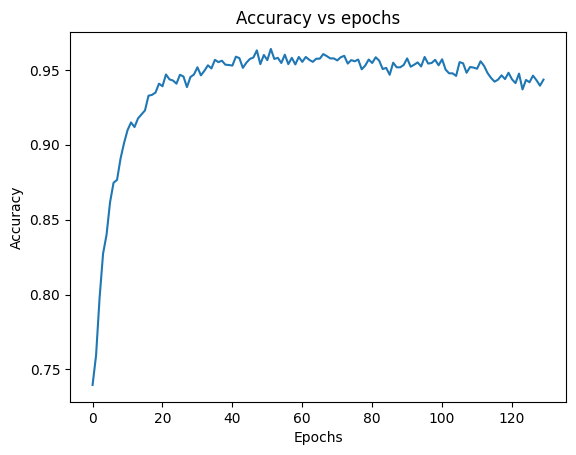

In [13]:
plt.plot(hist.history['dense_4_accuracy'])
plt.title("Accuracy vs epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Accuracy')

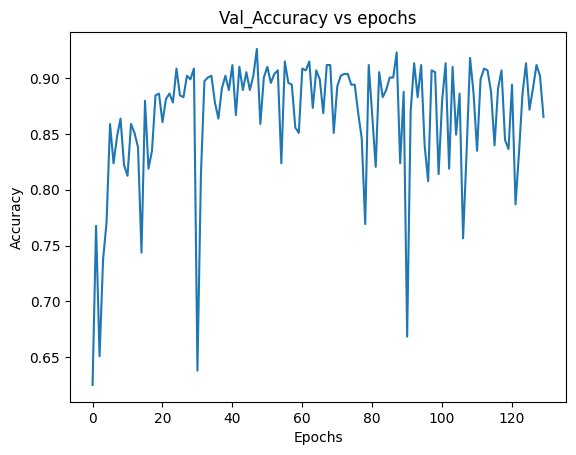

In [14]:
plt.plot(hist.history['val_dense_3_accuracy'])
plt.title("Val_Accuracy vs epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

In [15]:
prediction[1].shape

(624, 1)

In [16]:
output=[]
for i in prediction[2]:
    if i > 1-i:
        output.append(1)
    else:
        output.append(0)

In [17]:
true = 0
false = 0

for i in range(624):
    if output[i] == test_image_labels[i]:
        true += 1
    else:
        false += 1

In [18]:
print(true/624)

0.9262820512820513


In [19]:
from sklearn.metrics import confusion_matrix
# ... (Assuming you have your true_labels and predicted_labels)

cm = confusion_matrix(test_image_labels, output)
# plot_confusion_matrix(cm, target_names=['Normal', 'Pneumonia'])  # Optional: Add class labels


In [20]:
model.save('GoogleNet.h5')

In [21]:
pip install --upgrade scikit-learn 


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 51.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
Note: you may need to restart the kernel to use updated packages.


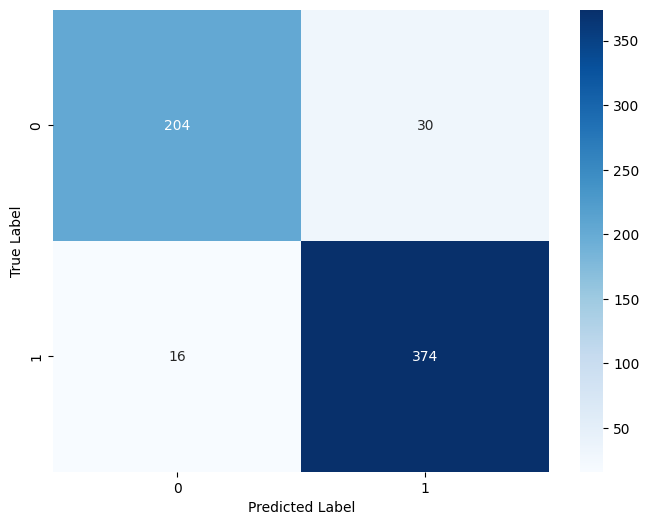

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()